### Modelo Red Neuronal (keras)

###### Paso 0 - Instalación de dependencias e importaciones de librerías

In [ ]:
# Install dependencies here
#%pip install keras
#%pip install tensorflow

%pip install shap

In [3]:
# Include your imports here

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import shap

#from keras.models import load_model
#from tensorflow.keras import Model
#from tensorflow.keras.layers import Dense, Flatten, Conv2D
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
# import seaborn as sns

# from sklearn.model_selection import GridSearchCV
#https://www.tensorflow.org/tutorials/quickstart/advanced

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


##### Paso 1 - Carga de datos y preprocesamiento

In [4]:
# Importamos el modelo de keras datasets Minst para facilitar el acceso y la lectura de datos
mnist = tf.keras.datasets.mnist

#Descargamos los datos de la database y realizamos las transformaciones y las normalizaciones pertienentes.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# Incluimos una nueva dimension a nuestro dataset.
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test= tf.convert_to_tensor(X_test, dtype=tf.float32)


#y_train = keras.utils.to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)


# Creamos la función que adapta los datos.
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

# Convertimos los datos al formato que posteriormente necesitaremos.
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

#Comprobamos que se ha incluido correctamente la nueva dimension a nuestro dataset.
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [5]:
#Se asemeja al Dataloader de Pytorch, transforamos a Tensor y realizamos los batches.
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

##### Paso 2 - Creación de la red neuronal

In [6]:
#Creación de la estructura de la red neuronal (Keras)

model = Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=(28,28,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

#Función de perdida
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#Optimizador
optimizer = tf.keras.optimizers.SGD()

#Compilamos
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


In [7]:
BATCH_SIZE = 128
EPOCHS = 10

#Entrenamos
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/10


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


469/469 [==============================] - 13s 27ms/step - loss: 0.6652 - accuracy: 0.8252 - val_loss: 0.3014 - val_accuracy: 0.9143
Epoch 2/10
469/469 [==============================] - 14s 29ms/step - loss: 0.2837 - accuracy: 0.9175 - val_loss: 0.2371 - val_accuracy: 0.9304
Epoch 3/10
469/469 [==============================] - 13s 29ms/step - loss: 0.2326 - accuracy: 0.9325 - val_loss: 0.2099 - val_accuracy: 0.9411
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1988 - accuracy: 0.9421 - val_loss: 0.1761 - val_accuracy: 0.9483
Epoch 5/10
469/469 [==============================] - 14s 31ms/step - loss: 0.1734 - accuracy: 0.9493 - val_loss: 0.1571 - val_accuracy: 0.9559
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1547 - accuracy: 0.9542 - val_loss: 0.1403 - val_accuracy: 0.9589
Epoch 7/10
469/469 [==============================] - 16s 33ms/step - loss: 0.1393 - accuracy: 0.9593 - val_loss: 0.1327 - val_accuracy: 0.9626
Epo

##### Paso 3 - Evaluación de resultados

In [8]:
#Resultados
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1063813716173172
Test accuracy: 0.9682999849319458


## Interpretabilidad del modelo - SHAP

In [9]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test[1:5])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


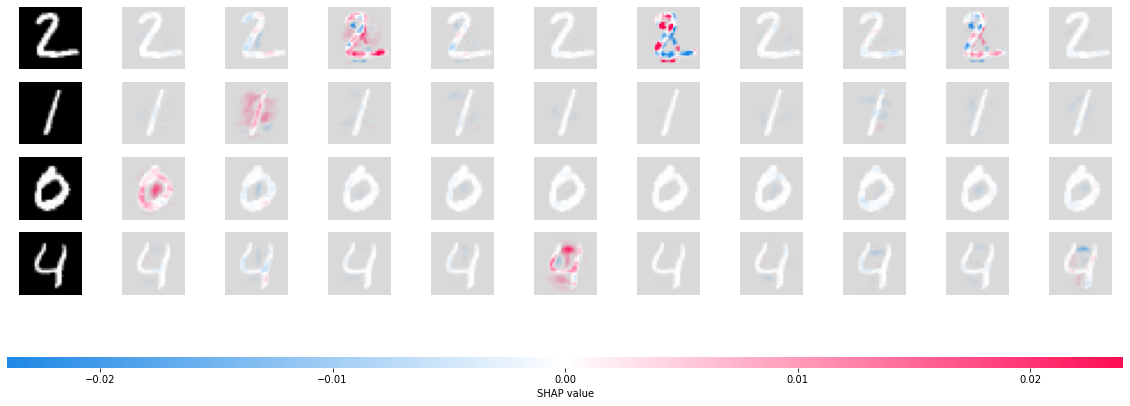

In [10]:
# plot the feature attributions
shap.image_plot(shap_values, X_test[1:5])